# Predicting physical activity based on weather ☀️

## Introduction

As a cycling activist, I am constantly confronted with the argument that cycling is only an activity for good weather days. I then respond with things like "it just comes down to the right clothing" or "what about taking a thermo can of tea with you for the ride" - Or look at the Dutch who ride their bikes every day in a country where it rains a lot. At this point, however, I asked myself how honest I am with myself here and how much bike I really ride on rainy days - or whether I am selling a story that I'm not living after. 

So I'm wondering: 

>To which extent could I predict my activity based on the whether forecast?

On the one hand, it would be exciting to know whether I possibly don't cycle that much in bad weather and simply pretend that it doesn't bother me.
In the next step, I would also find it exciting to create a kind of "Recommender System for Life" that takes into account all general conditions and, based on this, suggests activities for the day or deliberately schedules them in the calendar: For example, productivity slots, cooking, housework when the weather is bad for a long time, as well as social activities and sports based on the circumstances.

## Variables: 

### Independent variables (Causal)
- Weather
    - Precipitation (DR, RHX, RH)
    - Temperature (TN, TX)
    - Sun hours (SQ)
### Dependant variables (Effectual)
- Activitiy
- Steps
- Kilometres

## Data sources
- Apple Health
    - Strava
    - Mi Fit
    - iPhone

- KNMI - Koninklijk Nederlands Meteorologisch Instituut / Royal Dutch Meteorological Institute

## Considered period
2020 - Feb 2022 



### Past studies

<div class="csl-entry">Wen, X., Ma, Y., Yuan, B., &#38; Wang, F. (2019). Association among Weather Conditions, Ambient Air Temperature, and Sedentary Time in Chinese Adults. <i>BioMed Research International</i>, <i>2019</i>. https://doi.org/10.1155/2019/4010898</div>



# Data pre-processing / import


In [169]:
# Allow output of multiple queries at once
from IPython.display import SVG, display

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import seaborn as sns




# Apple Health data comes in XML format
import xmltodict
import json
import calendar 

# For merging multiple dfs
from functools import reduce


## Apple Health

In [170]:
apple_health = 'export.xml'
with open(apple_health, 'r') as xml_file:
    data = xmltodict.parse(xml_file.read())

records_list = data['HealthData']['Record']
df_ah = pd.DataFrame(records_list) # creating a dataframe with the data I will use
df_ah.head()

,@type,@sourceName,@sourceVersion,@unit,@creationDate,@startDate,@endDate,@value,@device,MetadataEntry
0,HKQuantityTypeIdentifierHeartRate,Mi Fit,202108031059,count/min,2021-08-04 18:52:36 +0100,2021-08-04 18:44:00 +0100,2021-08-04 18:44:59 +0100,74,NaN,NaN
1,HKQuantityTypeIdentifierHeartRate,Mi Fit,202108031059,count/min,2021-08-04 19:02:05 +0100,2021-08-04 18:57:00 +0100,2021-08-04 18:57:59 +0100,126,NaN,NaN
2,HKQuantityTypeIdentifierHeartRate,Mi Fit,202108031059,count/min,2021-08-04 19:02:05 +0100,2021-08-04 18:58:00 +0100,2021-08-04 18:58:59 +0100,74,NaN,NaN
3,HKQuantityTypeIdentifierHeartRate,Mi Fit,202108031059,count/min,2021-08-04 19:02:05 +0100,2021-08-04 18:59:00 +0100,2021-08-04 18:59:59 +0100,76,NaN,NaN
4,HKQuantityTypeIdentifierHeartRate,Mi Fit,202108031059,count/min,2021-08-04 19:23:00 +0100,2021-08-04 19:02:00 +0100,2021-08-04 19:02:59 +0100,63,NaN,NaN


## Google Location History

Thought about using Google Location History as well - yet this is less trivial than using the Apple Health source which bundles multible activity sources.

In [171]:

# google_loc = 'Records.json'
# with open(google_loc, 'r') as fh:
#     data = json.loads(fh.read())
# data = data['locations']



# for items in data['timelineObjects']:
#         try:
#             item = items['activitySegment']
#             start_coord = (int(item['startLocation']['latitudeE7'])/1e7, int(item['startLocation']['longitudeE7'])/1e7)
#             end_coord = (int(item['endLocation']['latitudeE7'])/1e7, int(item['endLocation']['longitudeE7'])/1e7)
#             distance = vincenty(start_coord, end_coord, miles=True)
#             dist_month = {"Month": month, "Distance":distance}


## NL Weather provider





In [172]:
# SOURCE: ROYAL NETHERLANDS METEOROLOGICAL INSTITUTE (KNMI)
# Comment: These time series are inhomogeneous because of station relocations and changes in observation techniques. As a result these series are not suitable for trend analysis. For climate change studies we refer to the homogenized series of daily data <http://www.knmi.nl/nederland-nu/klimatologie/daggegevens> or the Central Netherlands Temperature <http://www.knmi.nl/kennis-en-datacentrum/achtergrond/centraal-nederland-temperatuur-cnt>.
# 
# STN         LON(east)   LAT(north)  ALT(m)      NAME
# 215         4.437       52.141      -1.10       Voorschoten 
# 260         5.180       52.100      1.90        De Bilt     
# 330         4.122       51.992      11.90       Hoek van Holland
# 344         4.447       51.962      -4.30       Rotterdam   
# FHVEC     : Vectorgemiddelde windsnelheid (in 0.1 m/s). Zie http://www.knmi.nl/kennis-en-datacentrum/achtergrond/klimatologische-brochures-en-boeken / Vector mean windspeed (in 0.1 m/s)
# FG        : Etmaalgemiddelde windsnelheid (in 0.1 m/s) / Daily mean windspeed (in 0.1 m/s)
# FHX       : Hoogste uurgemiddelde windsnelheid (in 0.1 m/s) / Maximum hourly mean windspeed (in 0.1 m/s)
# FXX       : Hoogste windstoot (in 0.1 m/s) / Maximum wind gust (in 0.1 m/s)
# TN        : Minimum temperatuur (in 0.1 graden Celsius) / Minimum temperature (in 0.1 degrees Celsius)
# TX        : Maximum temperatuur (in 0.1 graden Celsius) / Maximum temperature (in 0.1 degrees Celsius)
# SQ        : Zonneschijnduur (in 0.1 uur) berekend uit de globale straling (-1 voor <0.05 uur) / Sunshine duration (in 0.1 hour) calculated from global radiation (-1 for <0.05 hour)
# DR        : Duur van de neerslag (in 0.1 uur) / Precipitation duration (in 0.1 hour)
# RH        : Etmaalsom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm) / Daily precipitation amount (in 0.1 mm) (-1 for <0.05 mm)
# RHX       : Hoogste uursom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm) / Maximum hourly precipitation amount (in 0.1 mm) (-1 for <0.05 mm)
# PX        : Hoogste uurwaarde van de luchtdruk herleid tot zeeniveau (in 0.1 hPa) / Maximum hourly sea level pressure (in 0.1 hPa)

df_w= pd.read_csv('result.txt', skiprows=21)
df_w.columns = df_w.columns.str.strip()

df_w.describe()

,# STN,YYYYMMDD,FHVEC,FG,FHX,FXX,TN,TX,SQ,PX
count,3160.000000,3.160000e+03,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000,3160.000000
mean,287.250000,2.020674e+07,43.629747,49.126899,72.405063,120.411392,70.731013,144.346835,50.981013,10189.521203
std,52.474364,6.147687e+03,26.565530,26.369727,32.727261,48.556449,53.714949,65.680021,44.139498,98.065038
min,215.000000,2.020010e+07,1.000000,7.000000,20.000000,30.000000,-110.000000,-48.000000,-1.000000,9796.000000
25%,248.750000,2.020072e+07,24.000000,30.000000,50.000000,80.000000,32.000000,93.750000,10.000000,10130.000000
50%,295.000000,2.021013e+07,38.000000,43.000000,70.000000,110.000000,68.000000,134.000000,43.000000,10197.000000
75%,333.500000,2.021082e+07,58.000000,63.000000,90.000000,150.000000,111.000000,198.000000,84.000000,10255.000000
max,344.000000,2.022023e+07,177.000000,178.000000,240.000000,390.000000,216.000000,346.000000,155.000000,10482.000000


Something seems fishy here: Why don't all values show up as numbers?

# Data Cleaning ✨

In [173]:
df_ah['@sourceName'].unique()

array(['Mi Fit', 'iPhone', 'Бананафон', 'Phil’s iPhone', 'Komoot',
       'Strava', 'Health', 'Clock'], dtype=object)

In [174]:
df_ah['@type'].unique()

array(['HKQuantityTypeIdentifierHeartRate',
       'HKQuantityTypeIdentifierStepCount',
       'HKQuantityTypeIdentifierDistanceWalkingRunning',
       'HKQuantityTypeIdentifierActiveEnergyBurned',
       'HKQuantityTypeIdentifierFlightsClimbed',
       'HKQuantityTypeIdentifierDistanceCycling',
       'HKQuantityTypeIdentifierHeadphoneAudioExposure',
       'HKQuantityTypeIdentifierWalkingDoubleSupportPercentage',
       'HKQuantityTypeIdentifierWalkingSpeed',
       'HKQuantityTypeIdentifierWalkingStepLength',
       'HKQuantityTypeIdentifierWalkingAsymmetryPercentage',
       'HKDataTypeSleepDurationGoal',
       'HKCategoryTypeIdentifierSleepAnalysis',
       'HKCategoryTypeIdentifierSexualActivity',
       'HKCategoryTypeIdentifierHeadphoneAudioExposureEvent'],
      dtype=object)

Another example that showed me how less I sometimes know about what is being tracked.

In particulaly I was wondering about 
- HKQuantityTypeIdentifierWalkingAsymmetryPercentage
- HKCategoryTypeIdentifierHeadphoneAudioExposure
- HKCategoryTypeIdentifierSexualActivity

Those variables are one of many indicators that Apple is moving more and more towards being a health company and while they advertise themselve as privacy-first company, I an wondering if this is going to be forever - or, as soon as everyone is part of the "walled garden", in their, what could become a monopoly positon they work more and more with the data. 


Variables that were of interest for my use case

- HKQuantityTypeIdentifierDistanceCycling
- HKQuantityTypeIdentifierDistanceWalkingRunning
- HKQuantityTypeIdentifierStepCount

In [175]:
searchfor = ['HKQuantityTypeIdentifierDistanceCycling', 'HKQuantityTypeIdentifierDistanceWalkingRunning', 'HKQuantityTypeIdentifierStepCount']
df_ah = df_ah[df_ah['@type'].str.contains('|'.join(searchfor))]

years = ['2020', '2021', '2022']

df_ah = df_ah[df_ah['@startDate'].str.contains('|'.join(years))]

# Exclude December 2021 since I went to Spain and it might distort the data
ex_range = ['2021-12']

df_ah = df_ah[~df_ah['@startDate'].str.contains('|'.join(ex_range))]


In [176]:
df_ah['@type'].unique()

array(['HKQuantityTypeIdentifierStepCount',
       'HKQuantityTypeIdentifierDistanceWalkingRunning',
       'HKQuantityTypeIdentifierDistanceCycling'], dtype=object)

In [177]:
df_ah.describe()

,@type,@sourceName,@sourceVersion,@unit,@creationDate,@startDate,@endDate,@value,@device,MetadataEntry
count,38388,38388,38388,38388,38388,38388,38388,38388,30360,286
unique,3,5,66,2,17270,21795,21892,12113,156,286
top,HKQuantityTypeIdentifierStepCount,iPhone,14.6,count,2022-02-16 21:12:49 +0100,2021-07-09 23:41:13 +0100,2021-07-06 21:39:09 +0100,8,"<<HKDevice: 0x2805db0c0>, name:iPhone, manufac...","[{'@key': 'HKMetadataKeySyncVersion', '@value'..."
freq,22940,24513,6959,22940,1039,4,4,673,581,1


For this project we will only need a few of those (steps, calories,cycling distance, exercise minutes, resting heart rate). Before we extract them, let's change the timestamps in the df to datetime objects:

In [178]:
# df_ah.drop(columns=['@creationDate', '@endDate'])


format = '%Y-%m-%d %H:%M:%S %z'
df_ah['@creationDate'] = pd.to_datetime(df_ah['@creationDate'],
                                     format=format)
df_ah['@startDate'] = pd.to_datetime(df_ah['@startDate'],
                                  format=format)
df_ah['@endDate'] = pd.to_datetime(df_ah['@endDate'],
                                format=format)

df_ah['@value'] = pd.to_numeric(df_ah['@value'], downcast="float")
df_ah['@duration'] = df_ah['@endDate'] - df_ah['@startDate']  



In [179]:
df_ah['@date'] = df_ah['@startDate'].dt.normalize()
df_ah['@date'] = df_ah['@date'].dt.tz_localize(None)


In [180]:
df_ah['@value'] = pd.to_numeric(df_ah['@value'], downcast="float")



In [181]:

d_steps =  df_ah[df_ah['@type'] == 'HKQuantityTypeIdentifierStepCount'].groupby('@date').sum()
d_foot =  df_ah[df_ah['@type'] == 'HKQuantityTypeIdentifierDistanceWalkingRunning'].groupby('@date').sum()
d_fiets =  df_ah[df_ah['@type'] == 'HKQuantityTypeIdentifierDistanceCycling'].groupby('@date').sum()

d_steps = d_steps.reset_index()
d_foot = d_foot.reset_index()
d_fiets = d_fiets.reset_index()


d_steps = d_steps.rename(columns={"@value":'d_steps'})
d_foot = d_foot.rename(columns={"@value":'d_foot'})
d_fiets = d_fiets.rename(columns={"@value":'d_fiets'})

d_steps.dtypes
# d_foot.dtypes

@date      datetime64[ns]
d_steps           float32
dtype: object

In [182]:
d_fiets

,@date,d_fiets
0,2021-01-31,5.310000
1,2021-02-02,1.858400
2,2021-02-03,10.047900
3,2021-02-04,21.525700
4,2021-02-06,4.361400
...,...,...
222,2022-02-10,33.511169
223,2022-02-12,56.942329
224,2022-02-13,10.248900
225,2022-02-14,7.750310


## Weather

In [183]:
df_w['@date'] = pd.to_datetime(df_w['YYYYMMDD'].astype(str), format='%Y%m%d')
df_w['@date']= df_w['@date'].dt.tz_localize(None)

df_w['DR']
df_w.dtypes


# STN                int64
YYYYMMDD             int64
FHVEC                int64
FG                   int64
FHX                  int64
FXX                  int64
TN                   int64
TX                   int64
SQ                   int64
DR                  object
RH                  object
RHX                 object
PX                   int64
@date       datetime64[ns]
dtype: object

## Structure

- Date

- Temp
- steps
- Distance
- Workout time total


## Merge

In [184]:
data_frames = [d_steps, d_foot, d_fiets, df_w]

df = reduce(lambda x,y: pd.merge(x,y, on='@date', how='outer'), data_frames)


df.index
# for df_item in data_frames:
#     df_item.set_index('@date', inplace=True)

# df  = pd.concat(data_frames,axis=1,sort=False).reset_index()


Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159],
           dtype='int64', length=3160)

# Explorative Analysis

In [185]:
df.columns



Index(['@date', 'd_steps', 'd_foot', 'd_fiets', '# STN', 'YYYYMMDD', 'FHVEC',
       'FG', 'FHX', 'FXX', 'TN', 'TX', 'SQ', 'DR', 'RH', 'RHX', 'PX'],
      dtype='object')

In [186]:
df.describe

<bound method NDFrame.describe of           @date  d_steps    d_foot  d_fiets  # STN  YYYYMMDD  FHVEC  FG  FHX  \
0    2020-01-01   2437.0  1.581487      NaN    215  20200101     30  35   40   
1    2020-01-01   2437.0  1.581487      NaN    260  20200101     24  27   30   
2    2020-01-01   2437.0  1.581487      NaN    330  20200101     51  55   60   
3    2020-01-01   2437.0  1.581487      NaN    344  20200101     27  32   40   
4    2020-01-02   6886.0  4.919736      NaN    215  20200102     50  50   80   
...         ...      ...       ...      ...    ...       ...    ...  ..  ...   
3155 2022-02-27      NaN       NaN      NaN    344  20220227     46  48   70   
3156 2022-02-28      NaN       NaN      NaN    215  20220228     35  36   60   
3157 2022-02-28      NaN       NaN      NaN    260  20220228     37  38   60   
3158 2022-02-28      NaN       NaN      NaN    330  20220228     63  64   80   
3159 2022-02-28      NaN       NaN      NaN    344  20220228     44  45   60   

     

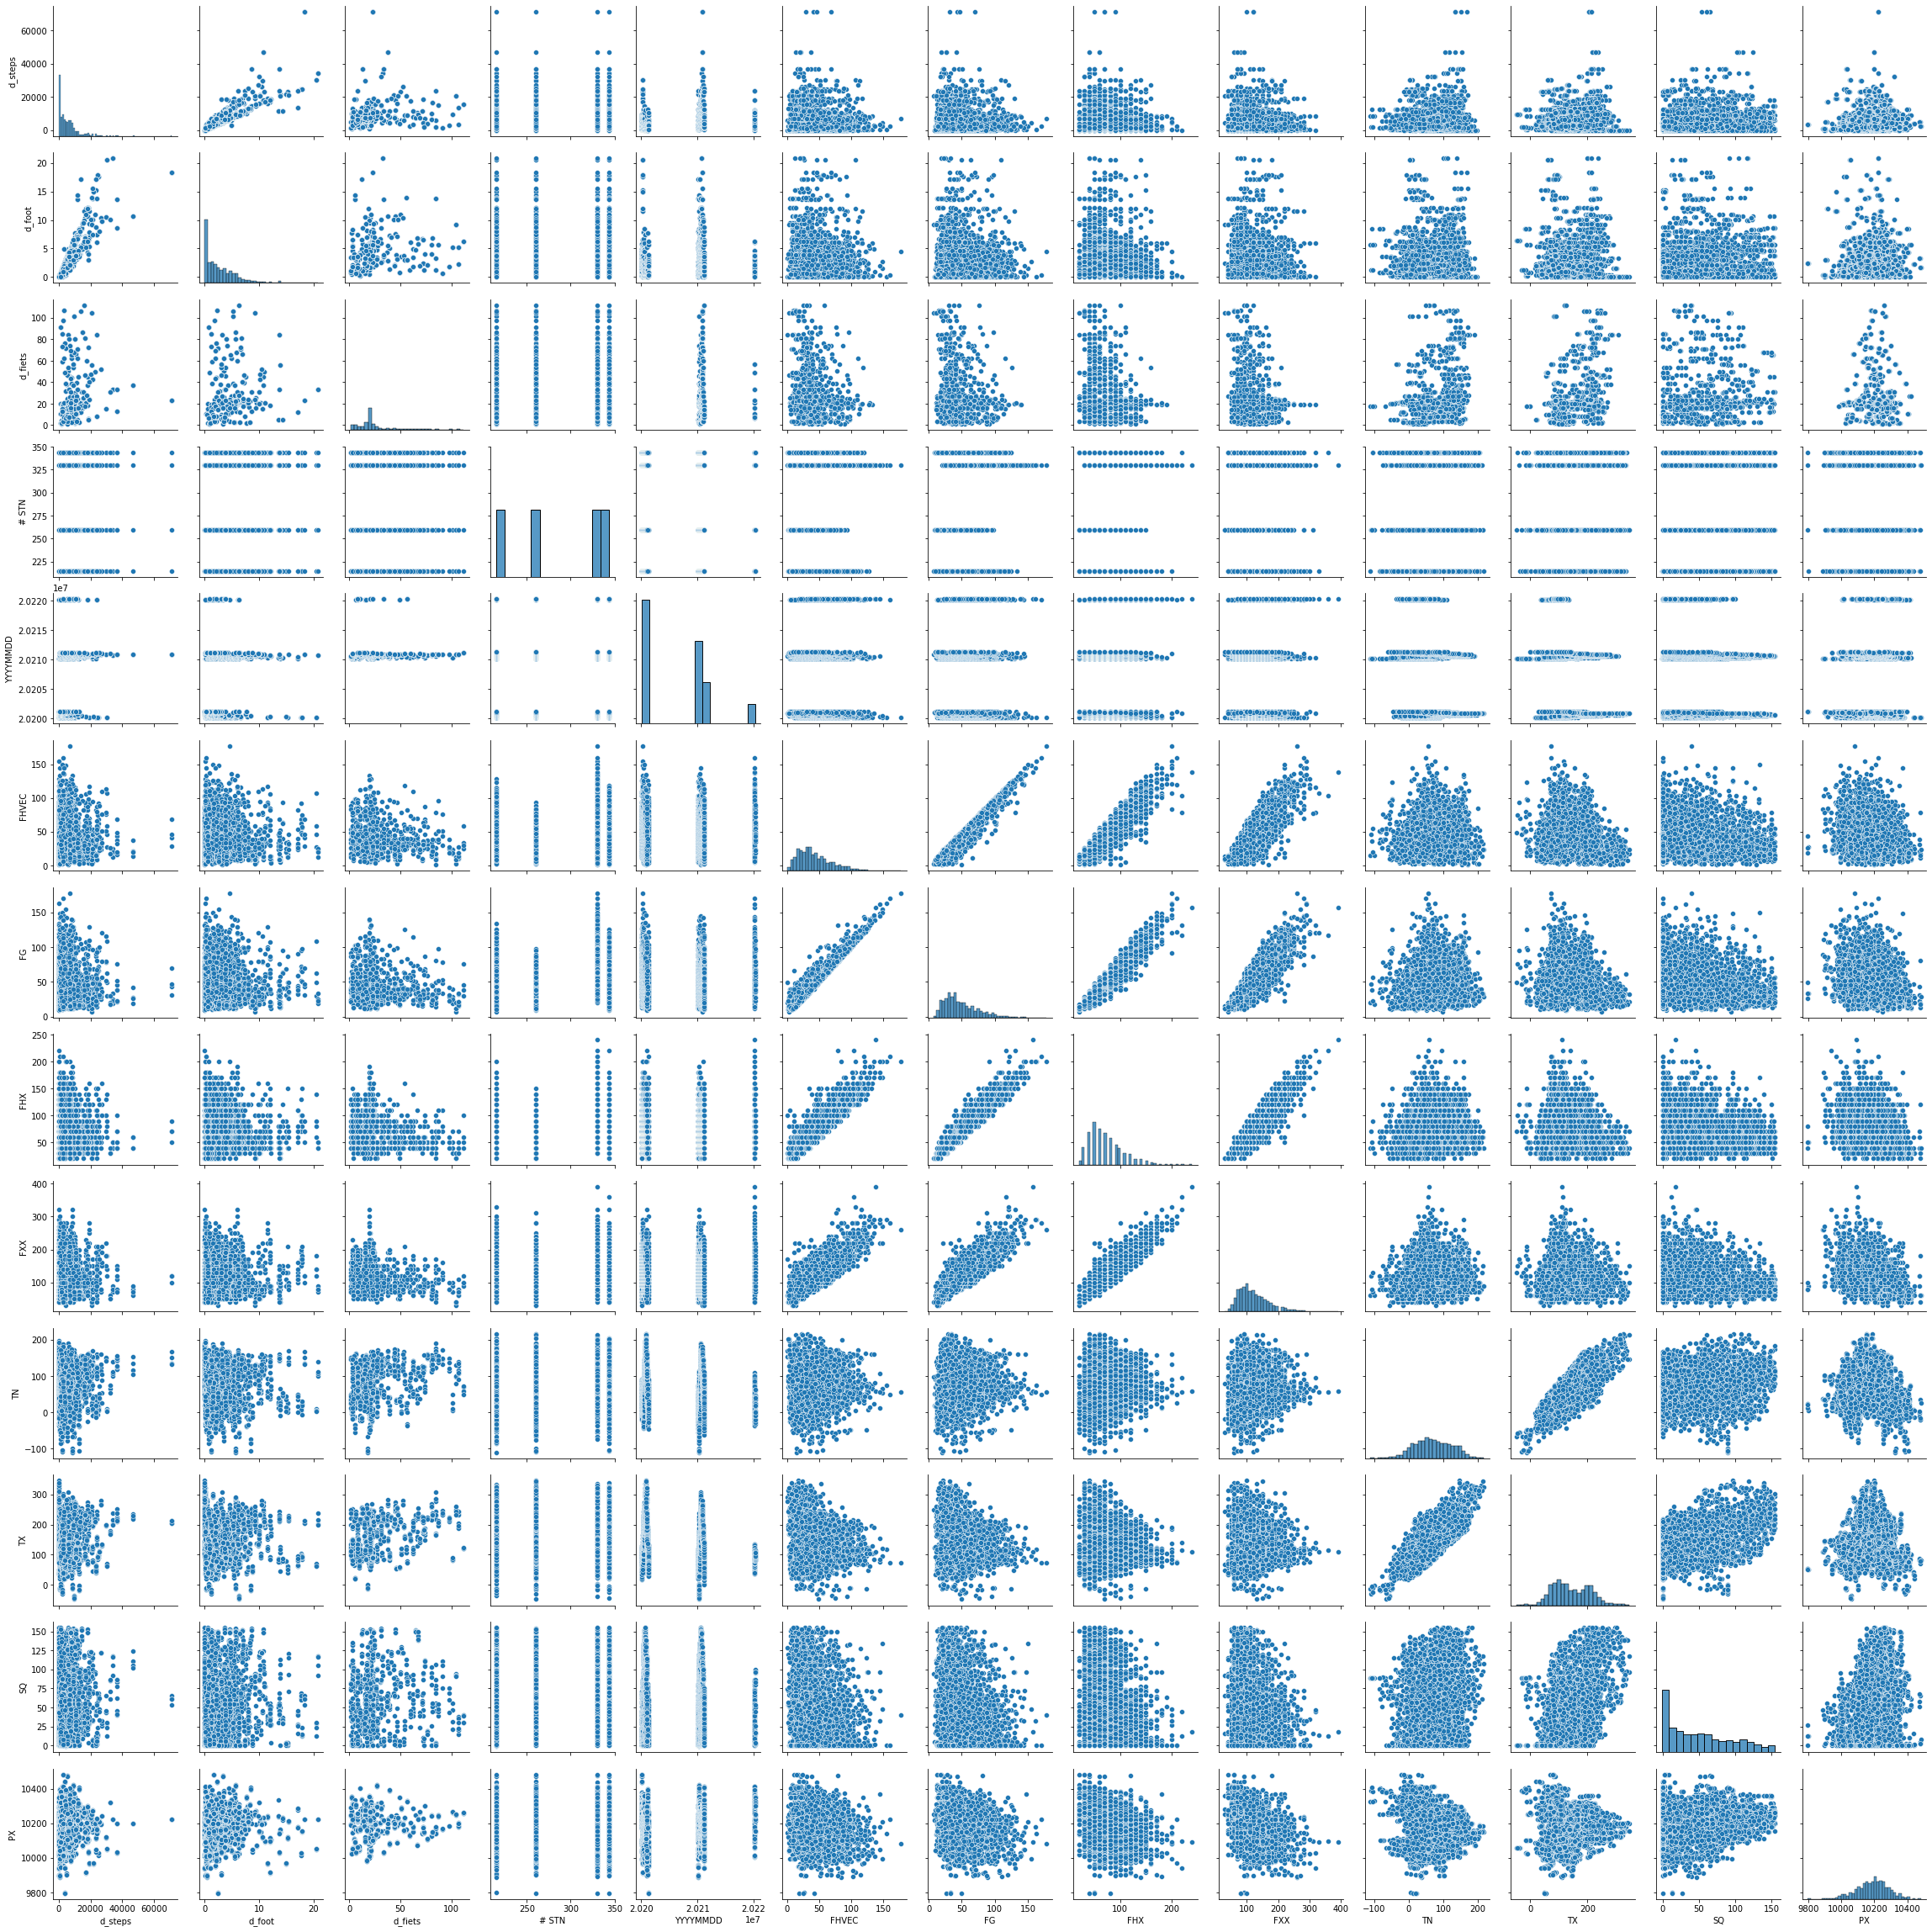

In [187]:
df_num = df.select_dtypes(exclude = ['object', 'bool'])
sns.pairplot(df_num)
plt.show() #using Matplotlib to show the plot



In [188]:
sns.heatmap(df_num, cmap="Reds",annot=True)


TypeError: float() argument must be a string or a number, not 'Timestamp'

# Machine Learning

In [ ]:

#libraries for building and evaluating my model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

ModuleNotFoundError: No module named 'sklearn'

# Evaluation: Applying for another iteration
